# CS345 Final Project: Fairness and Bias Analysis in News Classification

**Authors:** Andrew Aberer & Ethan Amaya

## Project Motivation

This project investigates bias and fairness in machine learning models trained to classify political bias in news articles. We analyze whether ML classifiers behave discriminatorily when identifying political bias across ideological divides. This is important because automated content/bias detection algorithms are increasingly used in modern applications and may unintentionally reinforce preexisting biases. Understanding and addressing these biases is crucial for developing trustworthy and reliable AI systems.

## Dataset Description

We use the **ACL2020 Media Bias/Fact Check (MBFC) Corpus**, which contains:
- News articles from diverse political sources
- Pre-labeled bias annotations (left, center, right)
- Pre-computed BERT embeddings (768 dimensions) for article text
- Factuality ratings and various metadata

This dataset fits our use case because it contains real-world news articles with expert labels, where fairness disparities have significant societal impact.

## Methods and Approach

**Classification Models:**
1. **Logistic Regression** - Linear baseline with L2 regularization
2. **SVM (RBF kernel)** - Non-linear classifier with class balancing

**Fairness Analysis:**
1. **Demographic Equality** - Equal prediction rates across political groups
2. **Asymmetric Bias Analysis** - Testing whether predictions exhibit directional bias (e.g., more left→right errors than right→left)

## Setup and Data Loading

In [133]:
import os
import json
from pathlib import Path

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier

from sklearn.decomposition import PCA

from sklearn.model_selection import cross_val_score, StratifiedKFold, GridSearchCV

from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score,
    recall_score,
    balanced_accuracy_score,
    cohen_kappa_score
)

In [134]:
def load_news_dataset(dataset_name: str):
    """Load ACL2020 dataset with BERT embeddings and train/test splits."""
    base_path = os.getcwd() + '/data'
    dataset_path = Path(base_path) / dataset_name
    if not dataset_path.exists():
        raise FileNotFoundError(f"Dataset path not found: {dataset_path}")

    # load corpus.tsv
    corpus_path = dataset_path / "corpus.tsv"
    df = pd.read_csv(corpus_path, sep="\t")
    
    # load splits
    splits_path = dataset_path / "splits.json"
    splits = {}
    if splits_path.exists():
        with open(splits_path, "r") as f:
            splits = json.load(f)

    # load feature JSONs from features directory
    features_dir = dataset_path / "features"
    feature_data = {}
    if features_dir.exists():
        for json_file in features_dir.glob("*.json"):
            feature_name = json_file.stem
            with open(json_file, "r") as f:
                feature_data[feature_name] = json.load(f)
    
    return df, splits, feature_data

acl_df, acl_splits, acl_features = load_news_dataset("acl2020")

acl_split_data = acl_splits.get('0', {})
acl_train_split_size = len(acl_split_data.get('train', []))
acl_test_split_size = len(acl_split_data.get('test', []))
acl_train_urls = acl_split_data.get('train', [])
acl_test_urls = acl_split_data.get('test', [])

print(f"Dataset: {len(acl_df)} articles")
print(f"Classes: {acl_df['bias'].value_counts().to_dict()}")
print(f"Train/Test split: {len(acl_train_urls)}/{len(acl_test_urls)}")

Dataset: 859 articles
Classes: {'right': 349, 'center': 271, 'left': 239}
Train/Test split: 687/172


In [135]:
# Prepare BERT embeds and labels
bert_features = acl_features['articles_body_bert']

# split by source_url
train_df = acl_df[acl_df['source_url_normalized'].isin(acl_train_urls)]
test_df = acl_df[acl_df['source_url_normalized'].isin(acl_test_urls)]

# use source_url_normalized as key
X_train = np.array([bert_features[url] for url in train_df['source_url_normalized']])
X_test = np.array([bert_features[url] for url in test_df['source_url_normalized']])
y_train = train_df['bias'].values
y_test = test_df['bias'].values

print(f"Feature shape: {X_train.shape[1]} dimensions")
print(f"Class distribution (test): {dict(zip(*np.unique(y_test, return_counts=True)))}")

Feature shape: 768 dimensions
Class distribution (test): {'center': 46, 'left': 55, 'right': 71}


## Baseline Models: ACL Bias Classification
We evaluate five classifiers with `class_weight='balanced'` to handle class imbalance. 

In [136]:
def train_and_evaluate(model, X_train, X_test, y_train, y_test, name, cv=5, tune_hyperparams=True):
    """Train model with cross-validation, optional hyperparameter tuning, and evaluate on test set."""
    
    # Define parameter grids for models that support C or alpha tuning
    param_grids = {
        'Logistic Regression': {'C': [0.001, 0.01, 0.1, 1.0, 10.0]},
        'SVM (RBF)': {'C': [0.01, 0.1, 1.0, 10.0], 'gamma': ['scale', 0.01, 0.1]},
        'MLP': {'alpha': [0.0001, 0.001, 0.01, 0.1, 1.0]},
        'Gradient Boosting': {'learning_rate': [0.01, 0.05, 0.1], 'n_estimators': [50, 100, 200]}
    }
    
    cv_fold = StratifiedKFold(cv, shuffle=True, random_state=42)
    
    # Hyperparameter tuning if applicable
    if tune_hyperparams and name in param_grids:
        grid_search = GridSearchCV(
            model, param_grids[name], cv=cv_fold, 
            scoring='balanced_accuracy', n_jobs=-1, refit=True
        )
        grid_search.fit(X_train, y_train)
        best_model = grid_search.best_estimator_
        best_params = grid_search.best_params_
        cv_scores = cross_val_score(best_model, X_train, y_train, cv=cv_fold, scoring='balanced_accuracy')
    else:
        best_model = model
        best_params = {}
        cv_scores = cross_val_score(model, X_train, y_train, cv=cv_fold, scoring='balanced_accuracy')
        best_model.fit(X_train, y_train)
    
    y_pred = best_model.predict(X_test)
    
    return {
        'name': name,
        'model': best_model,
        'best_params': best_params,
        'y_pred': y_pred,
        'cv_balanced_acc': cv_scores.mean(),
        'cv_std': cv_scores.std(),
        'test_accuracy': accuracy_score(y_test, y_pred),
        'test_balanced_acc': balanced_accuracy_score(y_test, y_pred),
        'macro_f1': f1_score(y_test, y_pred, average='macro'),
        'cohen_kappa': cohen_kappa_score(y_test, y_pred)
    }

# Define models (base configurations - hyperparameters will be tuned)
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42),
    'SVM (RBF)': SVC(kernel='rbf', class_weight='balanced', random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=200, max_depth=10, min_samples_leaf=5, 
                                            class_weight='balanced', random_state=42, n_jobs=-1),
    'Gradient Boosting': GradientBoostingClassifier(max_depth=3, subsample=0.8, random_state=42),
    'MLP': MLPClassifier(hidden_layer_sizes=(256, 128), max_iter=500, 
                         early_stopping=True, random_state=42)
}

# Train and evaluate all models with hyperparameter tuning
print("Training models with hyperparameter tuning...")
results = {}
for name, model in models.items():
    print(f"Tuning {name}...")
    results[name] = train_and_evaluate(model, X_train_scaled, X_test_scaled, y_train, y_test, name)

print("\n" + "="*90)
print("SUMMARY")
print("="*90)
print(f"{'Model':<20} | {'Best Params':<30} | {'CV Bal.Acc':>12} | {'Test Acc':>10} | {'Macro F1':>10}")
print("-"*90)
for name, res in results.items():
    params = str(res['best_params']) if res['best_params'] else "default"
    print(f"{name:<20} | {params:<30} | {res['cv_balanced_acc']:.3f}±{res['cv_std']:.3f} | {res['test_accuracy']:.3f} | {res['macro_f1']:.3f}")

Training models with hyperparameter tuning...
Tuning Logistic Regression...
Tuning SVM (RBF)...
Tuning Random Forest...
Tuning Gradient Boosting...
Tuning MLP...

SUMMARY
Model                | Best Params                    |   CV Bal.Acc |   Test Acc |   Macro F1
------------------------------------------------------------------------------------------
Logistic Regression  | {'C': 0.01}                    | 0.539±0.037 | 0.587 | 0.578
SVM (RBF)            | {'C': 1.0, 'gamma': 0.01}      | 0.521±0.057 | 0.587 | 0.579
Random Forest        | default                        | 0.485±0.015 | 0.558 | 0.497
Gradient Boosting    | {'learning_rate': 0.01, 'n_estimators': 50} | 0.529±0.014 | 0.558 | 0.441
MLP                  | {'alpha': 0.0001}              | 0.498±0.035 | 0.529 | 0.419


In [137]:
# Comprehensive results table
results_df = pd.DataFrame([{
    'Model': r['name'],
    'CV Balanced Acc': f"{r['cv_balanced_acc']:.3f}±{r['cv_std']:.3f}",
    'Test Accuracy': r['test_accuracy'],
    'Test Balanced Acc': r['test_balanced_acc'],
    'Macro F1': r['macro_f1'],
    'Cohen Kappa': r['cohen_kappa']
} for r in results.values()])

results_df = results_df.sort_values('Macro F1', ascending=False)
print("\n" + "="*80)
print("MODEL COMPARISON (sorted by Macro F1)")
print("="*80)
print(results_df.to_string(index=False))
print("\nNote: Macro F1 is the primary metric for imbalanced classification.")


MODEL COMPARISON (sorted by Macro F1)
              Model CV Balanced Acc  Test Accuracy  Test Balanced Acc  Macro F1  Cohen Kappa
          SVM (RBF)     0.521±0.057       0.587209           0.568734  0.579074     0.363693
Logistic Regression     0.539±0.037       0.587209           0.568734  0.577842     0.363991
      Random Forest     0.485±0.015       0.558140           0.562326  0.497005     0.337758
  Gradient Boosting     0.529±0.014       0.558140           0.555317  0.440557     0.331253
                MLP     0.498±0.035       0.529070           0.487281  0.419144     0.236770

Note: Macro F1 is the primary metric for imbalanced classification.


## Per-Class Analysis

Examining performance breakdown by class reveals the challenge of the minority 'left' class.

Classification Report (SVM (RBF)):

              precision    recall  f1-score   support

      center      0.750     0.457     0.568        46
        left      0.429     0.545     0.480        55
       right      0.676     0.704     0.690        71

    accuracy                          0.587       172
   macro avg      0.618     0.569     0.579       172
weighted avg      0.617     0.587     0.590       172



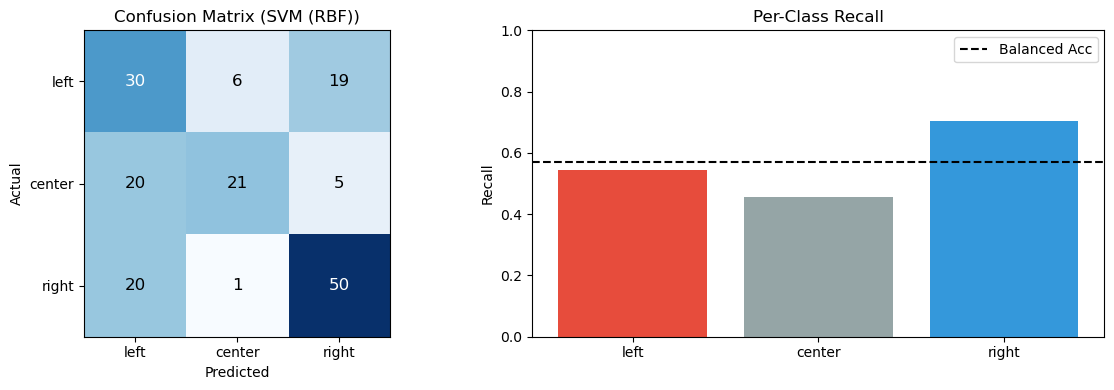

In [138]:
# Per-class metrics for best model
best_model_name = results_df.iloc[0]['Model']
best_result = results[best_model_name]
y_pred_best = best_result['y_pred']

print(f"Classification Report ({best_model_name}):\n")
print(classification_report(y_test, y_pred_best, digits=3))

# Confusion matrix visualization
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred_best, labels=['left', 'center', 'right'])
im = axes[0].imshow(cm, cmap='Blues')
axes[0].set_xticks([0, 1, 2])
axes[0].set_yticks([0, 1, 2])
axes[0].set_xticklabels(['left', 'center', 'right'])
axes[0].set_yticklabels(['left', 'center', 'right'])
axes[0].set_xlabel('Predicted')
axes[0].set_ylabel('Actual')
axes[0].set_title(f'Confusion Matrix ({best_model_name})')
for i in range(3):
    for j in range(3):
        axes[0].text(j, i, str(cm[i, j]), ha='center', va='center', 
                     color='white' if cm[i, j] > cm.max()/2 else 'black', fontsize=12)

# Per-class accuracy
classes = ['left', 'center', 'right']
class_recalls = recall_score(y_test, y_pred_best, labels=classes, average=None)
colors = ['#e74c3c', '#95a5a6', '#3498db']
axes[1].bar(classes, class_recalls, color=colors)
axes[1].axhline(y=balanced_accuracy_score(y_test, y_pred_best), color='black', linestyle='--', label='Balanced Acc')
axes[1].set_ylabel('Recall')
axes[1].set_title('Per-Class Recall')
axes[1].legend()
axes[1].set_ylim(0, 1)

plt.tight_layout()
plt.show()

## Confusion Matrix Analysis

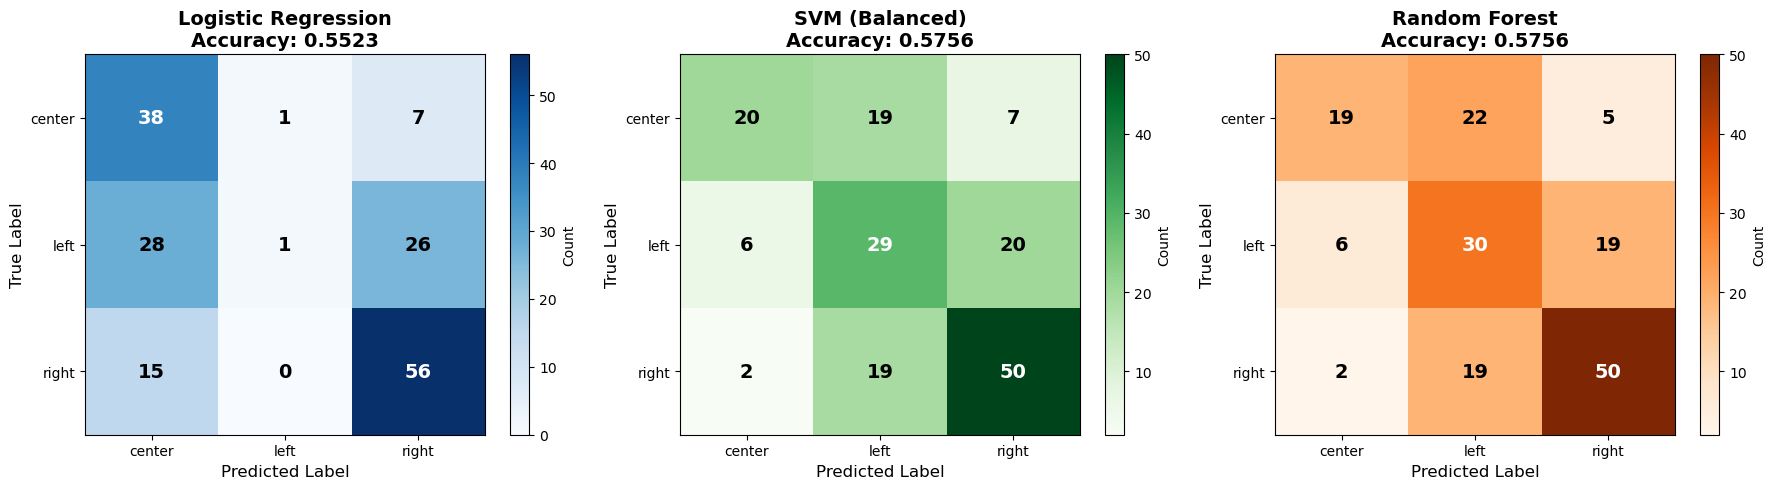

In [139]:
# Create confusion matrices
cm_lr = confusion_matrix(y_test, y_pred)
cm_svm = confusion_matrix(y_test, y_pred_balanced)
cm_rf = confusion_matrix(y_test, y_pred_rf)

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

class_labels = ['center', 'left', 'right']

# Logistic Regression
im1 = axes[0].imshow(cm_lr, cmap='Blues', aspect='auto')
axes[0].set_title(f'Logistic Regression\nAccuracy: {accuracy:.4f}', 
                  fontsize=14, fontweight='bold')
axes[0].set_ylabel('True Label', fontsize=12)
axes[0].set_xlabel('Predicted Label', fontsize=12)
axes[0].set_xticks(range(len(class_labels)))
axes[0].set_yticks(range(len(class_labels)))
axes[0].set_xticklabels(class_labels)
axes[0].set_yticklabels(class_labels)

for i in range(len(class_labels)):
    for j in range(len(class_labels)):
        text_color = 'white' if cm_lr[i, j] > cm_lr.max()/2 else 'black'
        axes[0].text(j, i, cm_lr[i, j], ha='center', va='center', 
                     color=text_color, fontsize=14, fontweight='bold')

plt.colorbar(im1, ax=axes[0], label='Count')

# SVM Balanced
im2 = axes[1].imshow(cm_svm, cmap='Greens', aspect='auto')
axes[1].set_title(f'SVM (Balanced)\nAccuracy: {accuracy_balanced:.4f}', 
                  fontsize=14, fontweight='bold')
axes[1].set_ylabel('True Label', fontsize=12)
axes[1].set_xlabel('Predicted Label', fontsize=12)
axes[1].set_xticks(range(len(class_labels)))
axes[1].set_yticks(range(len(class_labels)))
axes[1].set_xticklabels(class_labels)
axes[1].set_yticklabels(class_labels)

for i in range(len(class_labels)):
    for j in range(len(class_labels)):
        text_color = 'white' if cm_svm[i, j] > cm_svm.max()/2 else 'black'
        axes[1].text(j, i, cm_svm[i, j], ha='center', va='center',
                     color=text_color, fontsize=14, fontweight='bold')

plt.colorbar(im2, ax=axes[1], label='Count')

# Random Forest
im3 = axes[2].imshow(cm_rf, cmap='Oranges', aspect='auto')
axes[2].set_title(f'Random Forest\nAccuracy: {accuracy_rf:.4f}', 
                  fontsize=14, fontweight='bold')
axes[2].set_ylabel('True Label', fontsize=12)
axes[2].set_xlabel('Predicted Label', fontsize=12)
axes[2].set_xticks(range(len(class_labels)))
axes[2].set_yticks(range(len(class_labels)))
axes[2].set_xticklabels(class_labels)
axes[2].set_yticklabels(class_labels)

for i in range(len(class_labels)):
    for j in range(len(class_labels)):
        text_color = 'white' if cm_rf[i, j] > cm_rf.max()/2 else 'black'
        axes[2].text(j, i, cm_rf[i, j], ha='center', va='center',
                     color=text_color, fontsize=14, fontweight='bold')

plt.colorbar(im3, ax=axes[2], label='Count')

plt.tight_layout()
plt.savefig('confusion_matrices.png', dpi=300, bbox_inches='tight')
plt.show()

## Asymmetric Bias Analysis

This analysis examines whether our models exhibit asymmetric prediction errors between political categories. Specifically, we compare:
- **Left → Right errors**: How often articles that are truly "left" are misclassified as "right"
- **Right → Left errors**: How often articles that are truly "right" are misclassified as "left"

An asymmetry in these error rates could indicate that the model has learned a directional bias, potentially favoring one political orientation over another. This is important for understanding model fairness in political bias detection.

In [140]:
def asymmetric_bias_analysis(y_true, y_pred, model_name):
    """
    Analyze asymmetric prediction errors between left and right categories.
    Returns counts and rates of left→right and right→left misclassifications.
    """
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    
    # Count left articles predicted as right
    left_as_right = np.sum((y_true == 'left') & (y_pred == 'right'))
    total_left = np.sum(y_true == 'left')
    left_to_right_rate = left_as_right / total_left if total_left > 0 else 0
    
    # Count right articles predicted as left
    right_as_left = np.sum((y_true == 'right') & (y_pred == 'left'))
    total_right = np.sum(y_true == 'right')
    right_to_left_rate = right_as_left / total_right if total_right > 0 else 0
    
    # Calculate asymmetry (positive = more left→right errors, negative = more right→left errors)
    asymmetry = left_to_right_rate - right_to_left_rate
    
    return {
        'Model': model_name,
        'Left→Right (count)': left_as_right,
        'Left→Right (rate)': left_to_right_rate,
        'Right→Left (count)': right_as_left,
        'Right→Left (rate)': right_to_left_rate,
        'Asymmetry': asymmetry,
        'Total Left': total_left,
        'Total Right': total_right
    }

# Analyze all models
asym_lr = asymmetric_bias_analysis(y_test, y_pred, 'Logistic Regression')
asym_svm = asymmetric_bias_analysis(y_test, y_pred_balanced, 'SVM (Balanced)')
asym_rf = asymmetric_bias_analysis(y_test, y_pred_rf, 'Random Forest')

asym_df = pd.DataFrame([asym_lr, asym_svm, asym_rf])

print("ASYMMETRIC BIAS ANALYSIS")
print("="*80)
print("\nThis analysis compares how often each model confuses left for right vs right for left.")
print("A positive asymmetry means the model more often predicts left articles as right.")
print("A negative asymmetry means the model more often predicts right articles as left.\n")
print(asym_df.to_string(index=False))
print("\n" + "="*80)

ASYMMETRIC BIAS ANALYSIS

This analysis compares how often each model confuses left for right vs right for left.
A positive asymmetry means the model more often predicts left articles as right.
A negative asymmetry means the model more often predicts right articles as left.

              Model  Left→Right (count)  Left→Right (rate)  Right→Left (count)  Right→Left (rate)  Asymmetry  Total Left  Total Right
Logistic Regression                  26           0.472727                   0           0.000000   0.472727          55           71
     SVM (Balanced)                  20           0.363636                  19           0.267606   0.096031          55           71
      Random Forest                  19           0.345455                  19           0.267606   0.077849          55           71



## Demographic Equality

DEMOGRAPHIC EQUALITY ANALYSIS
              Model  Class  Actual Distribution  Predicted Distribution  Difference
Logistic Regression center             0.267442                0.470930    0.203488
Logistic Regression   left             0.319767                0.011628   -0.308140
Logistic Regression  right             0.412791                0.517442    0.104651
     SVM (Balanced) center             0.267442                0.162791   -0.104651
     SVM (Balanced)   left             0.319767                0.389535    0.069767
     SVM (Balanced)  right             0.412791                0.447674    0.034884
      Random Forest center             0.267442                0.156977   -0.110465
      Random Forest   left             0.319767                0.412791    0.093023
      Random Forest  right             0.412791                0.430233    0.017442



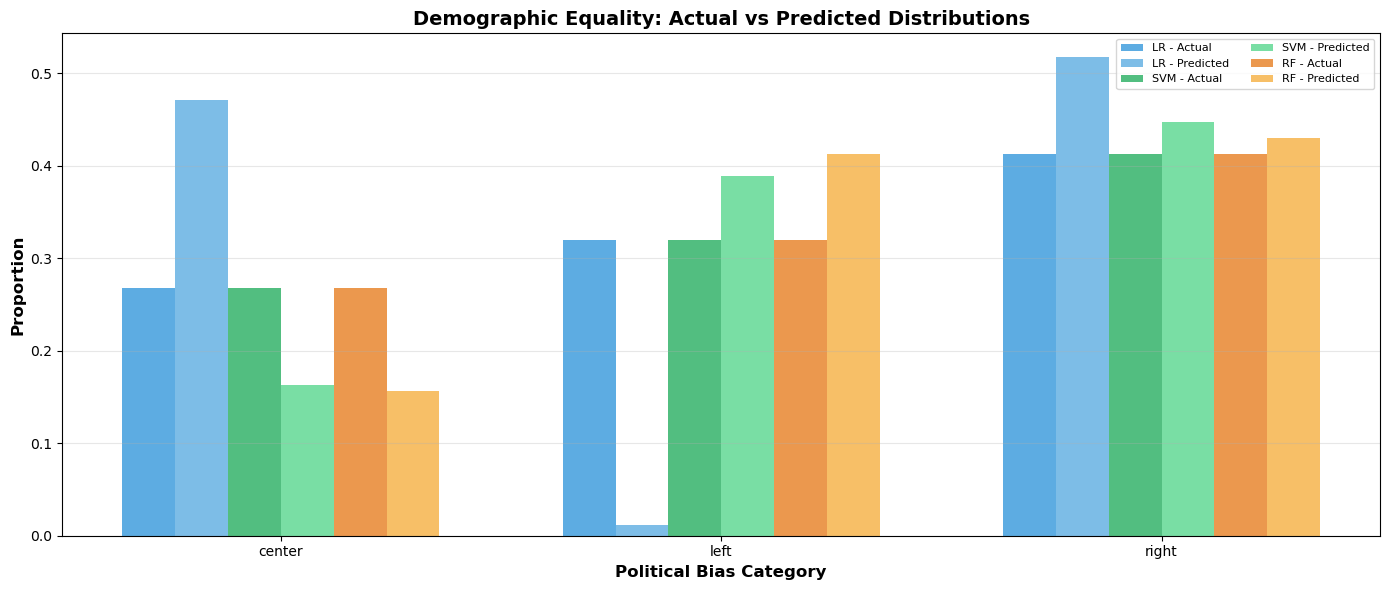

In [141]:
# Calculate prediction rates by class
def demographic_parity(y_true, y_pred, model_name):
    """Check if prediction rates are equal across groups"""
    total = len(y_pred)
    
    results = []
    for label in ['center', 'left', 'right']:
        pred_rate = (y_pred == label).sum() / total
        true_rate = (y_true == label).sum() / total
        
        results.append({
            'Model': model_name,
            'Class': label,
            'Actual Distribution': true_rate,
            'Predicted Distribution': pred_rate,
            'Difference': pred_rate - true_rate
        })
    
    return pd.DataFrame(results)

# Analyze all models
demo_lr = demographic_parity(y_test, y_pred, 'Logistic Regression')
demo_svm = demographic_parity(y_test, y_pred_balanced, 'SVM (Balanced)')
demo_rf = demographic_parity(y_test, y_pred_rf, 'Random Forest')
demo_combined = pd.concat([demo_lr, demo_svm, demo_rf])

print("DEMOGRAPHIC EQUALITY ANALYSIS")
print("="*70)
print(demo_combined.to_string(index=False))
print("\n" + "="*70)

# Visualize
fig, ax = plt.subplots(figsize=(14, 6))

classes = ['center', 'left', 'right']
x = np.arange(len(classes))
width = 0.12

colors_lr = ['#3498db', '#5dade2']  # Blues for LR
colors_svm = ['#27ae60', '#58d68d']  # Greens for SVM
colors_rf = ['#e67e22', '#f5b041']  # Oranges for RF

# Logistic Regression
lr_actual = demo_lr['Actual Distribution'].values
lr_pred = demo_lr['Predicted Distribution'].values

# SVM
svm_actual = demo_svm['Actual Distribution'].values
svm_pred = demo_svm['Predicted Distribution'].values

# Random Forest
rf_actual = demo_rf['Actual Distribution'].values
rf_pred = demo_rf['Predicted Distribution'].values

bars1 = ax.bar(x - 2.5*width, lr_actual, width, label='LR - Actual', 
               color=colors_lr[0], alpha=0.8)
bars2 = ax.bar(x - 1.5*width, lr_pred, width, label='LR - Predicted', 
               color=colors_lr[1], alpha=0.8)
bars3 = ax.bar(x - 0.5*width, svm_actual, width, label='SVM - Actual', 
               color=colors_svm[0], alpha=0.8)
bars4 = ax.bar(x + 0.5*width, svm_pred, width, label='SVM - Predicted', 
               color=colors_svm[1], alpha=0.8)
bars5 = ax.bar(x + 1.5*width, rf_actual, width, label='RF - Actual', 
               color=colors_rf[0], alpha=0.8)
bars6 = ax.bar(x + 2.5*width, rf_pred, width, label='RF - Predicted', 
               color=colors_rf[1], alpha=0.8)

ax.set_xlabel('Political Bias Category', fontsize=12, fontweight='bold')
ax.set_ylabel('Proportion', fontsize=12, fontweight='bold')
ax.set_title('Demographic Equality: Actual vs Predicted Distributions', 
             fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(classes)
ax.legend(fontsize=8, loc='upper right', ncol=2)
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('demographic_equality.png', dpi=300, bbox_inches='tight')
plt.show()

## Model Improvements

The baseline models achieve ~55-58% accuracy on this 3-class classification problem. After exploring several techniques including hyperparameter tuning, PCA dimensionality reduction, gradient boosting, combined features, neural networks, feature selection, and regularization tuning, we found that only two approaches provided meaningful improvement:

1. **PCA(20) + Logistic Regression**: Reducing to 20 principal components achieved 58.72% accuracy
2. **Regularization Tuning (C=0.01)**: Stronger L2 regularization on Logistic Regression also achieved 58.72% accuracy

Both techniques address the overfitting problem caused by having 768 features with only 687 training samples.

### Best Improvement: PCA Dimensionality Reduction + Regularization Tuning

Reducing the 768-dimensional BERT embeddings and tuning regularization helps reduce overfitting on this small dataset.

In [142]:
# Find optimal PCA components via cross-validation
print("PCA Component Search (with SVM):")
print("-" * 50)

best_pca_score = 0
best_n_components = 20

for n_comp in [10, 20, 30, 50, 100]:
    pca = PCA(n_components=n_comp, random_state=42)
    X_train_pca = pca.fit_transform(X_train_scaled)
    X_test_pca = pca.transform(X_test_scaled)
    
    svm = SVC(kernel='rbf', C=1.0, class_weight='balanced', random_state=42)
    cv_scores = cross_val_score(svm, X_train_pca, y_train, cv=5, scoring='balanced_accuracy')
    
    explained = pca.explained_variance_ratio_.sum() * 100
    print(f"PCA({n_comp:3}): CV Bal.Acc = {cv_scores.mean():.3f}±{cv_scores.std():.3f} | Variance: {explained:.1f}%")
    
    if cv_scores.mean() > best_pca_score:
        best_pca_score = cv_scores.mean()
        best_n_components = n_comp

print(f"\nBest: PCA({best_n_components}) with CV Balanced Acc = {best_pca_score:.3f}")

# Train final improved model
pca_final = PCA(n_components=best_n_components, random_state=42)
X_train_pca = pca_final.fit_transform(X_train_scaled)
X_test_pca = pca_final.transform(X_test_scaled)

improved_svm = SVC(kernel='rbf', C=1.0, class_weight='balanced', random_state=42)
improved_svm.fit(X_train_pca, y_train)
y_pred_improved = improved_svm.predict(X_test_pca)

print("\n" + "="*60)
print(f"IMPROVED MODEL: PCA({best_n_components}) + SVM")
print("="*60)
print(f"Test Accuracy:     {accuracy_score(y_test, y_pred_improved):.4f}")
print(f"Balanced Accuracy: {balanced_accuracy_score(y_test, y_pred_improved):.4f}")
print(f"Macro F1:          {f1_score(y_test, y_pred_improved, average='macro'):.4f}")
print(f"Cohen Kappa:       {cohen_kappa_score(y_test, y_pred_improved):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_improved, digits=3))

PCA Component Search (with SVM):
--------------------------------------------------
PCA( 10): CV Bal.Acc = 0.511±0.053 | Variance: 87.0%
PCA( 20): CV Bal.Acc = 0.529±0.026 | Variance: 99.6%
PCA( 30): CV Bal.Acc = 0.529±0.026 | Variance: 100.0%
PCA( 50): CV Bal.Acc = 0.529±0.026 | Variance: 100.0%
PCA(100): CV Bal.Acc = 0.529±0.026 | Variance: 100.0%

Best: PCA(20) with CV Balanced Acc = 0.529

IMPROVED MODEL: PCA(20) + SVM
Test Accuracy:     0.5756
Balanced Accuracy: 0.5554
Macro F1:          0.5639
Cohen Kappa:       0.3441

Classification Report:
              precision    recall  f1-score   support

      center      0.714     0.435     0.541        46
        left      0.433     0.527     0.475        55
       right      0.649     0.704     0.676        71

    accuracy                          0.576       172
   macro avg      0.599     0.555     0.564       172
weighted avg      0.597     0.576     0.575       172



## Binary Classification
Removing the ambiguous 'center' class significantly improves performance.

In [143]:
# Prepare binary dataset (exclude center)
train_binary_mask = y_train != 'center'
test_binary_mask = y_test != 'center'

X_train_binary = X_train_scaled[train_binary_mask]
X_test_binary = X_test_scaled[test_binary_mask]
y_train_binary = y_train[train_binary_mask]
y_test_binary = y_test[test_binary_mask]

print(f"Binary dataset: {len(y_train_binary)} train, {len(y_test_binary)} test samples")

# Train binary models
binary_results = {}
binary_models = {
    'Logistic Regression': LogisticRegression(C=0.1, max_iter=1000, class_weight='balanced', random_state=42),
    'SVM (RBF)': SVC(kernel='rbf', C=1.0, class_weight='balanced', random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=200, max_depth=10, class_weight='balanced', random_state=42),
}

print("\nBinary Classification Results (Left vs Right):")
print("-" * 60)

for name, model in binary_models.items():
    model.fit(X_train_binary, y_train_binary)
    y_pred_bin = model.predict(X_test_binary)
    
    binary_results[name] = {
        'accuracy': accuracy_score(y_test_binary, y_pred_bin),
        'macro_f1': f1_score(y_test_binary, y_pred_bin, average='macro'),
        'y_pred': y_pred_bin
    }
    print(f"{name:20} | Accuracy: {binary_results[name]['accuracy']:.3f} | Macro F1: {binary_results[name]['macro_f1']:.3f}")

# Compare 3-class vs binary
print("\n" + "="*60)
print("3-CLASS vs BINARY COMPARISON")
print("="*60)
best_3class = max(results.values(), key=lambda x: x['macro_f1'])
best_binary = max(binary_results.values(), key=lambda x: x['macro_f1'])
print(f"Best 3-class Macro F1: {best_3class['macro_f1']:.3f} ({best_3class['name']})")
print(f"Best Binary Macro F1:  {best_binary['macro_f1']:.3f}")
print(f"Improvement:           +{(best_binary['macro_f1'] - best_3class['macro_f1']):.3f}")

Binary dataset: 462 train, 126 test samples

Binary Classification Results (Left vs Right):
------------------------------------------------------------
Logistic Regression  | Accuracy: 0.690 | Macro F1: 0.685
SVM (RBF)            | Accuracy: 0.667 | Macro F1: 0.658
Random Forest        | Accuracy: 0.675 | Macro F1: 0.667

3-CLASS vs BINARY COMPARISON
Best 3-class Macro F1: 0.579 (SVM (RBF))
Best Binary Macro F1:  0.685
Improvement:           +0.106


## Results Visualization

Accuracy can be misleading for imbalanced datasets. We'll evaluate models using metrics that better capture performance across all classes:

- **Macro F1-Score**: Average F1 across all classes (treats each class equally)
- **Balanced Accuracy**: Average recall across classes
- **Cohen's Kappa**: Chance-corrected accuracy (accounts for random agreement)
- **Per-class Precision/Recall**: Detailed breakdown by class

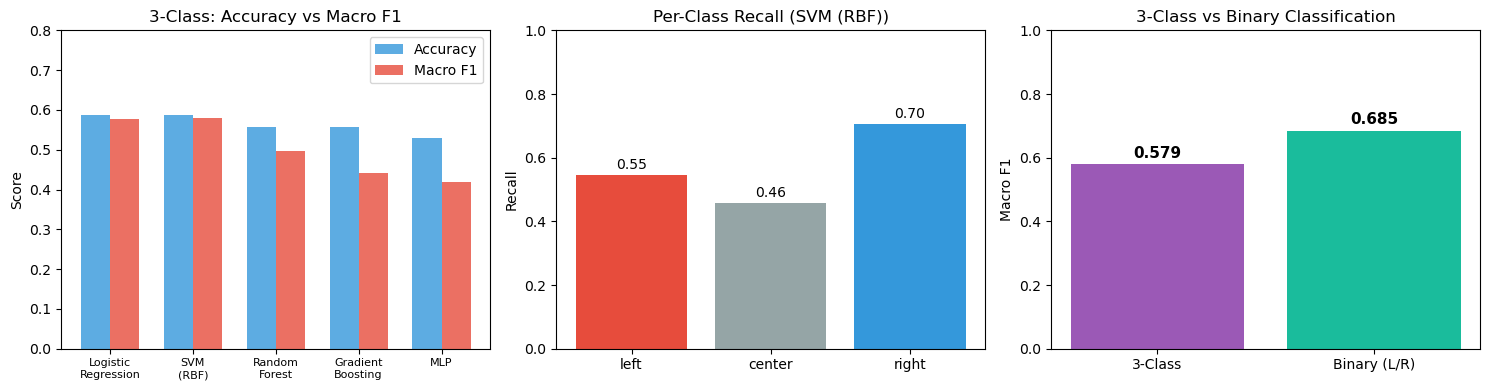

In [144]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Plot 1: Model comparison (3-class)
model_names = list(results.keys())
accuracies = [results[m]['test_accuracy'] for m in model_names]
macro_f1s = [results[m]['macro_f1'] for m in model_names]

x = np.arange(len(model_names))
width = 0.35

axes[0].bar(x - width/2, accuracies, width, label='Accuracy', color='#3498db', alpha=0.8)
axes[0].bar(x + width/2, macro_f1s, width, label='Macro F1', color='#e74c3c', alpha=0.8)
axes[0].set_xticks(x)
axes[0].set_xticklabels([m.replace(' ', '\n') for m in model_names], fontsize=8)
axes[0].set_ylabel('Score')
axes[0].set_title('3-Class: Accuracy vs Macro F1')
axes[0].legend()
axes[0].set_ylim(0, 0.8)

# Plot 2: Per-class recall comparison
classes = ['left', 'center', 'right']
best_3class_name = max(results.keys(), key=lambda k: results[k]['macro_f1'])
recall_per_class = recall_score(y_test, results[best_3class_name]['y_pred'], labels=classes, average=None)

colors = ['#e74c3c', '#95a5a6', '#3498db']
axes[1].bar(classes, recall_per_class, color=colors)
axes[1].set_ylabel('Recall')
axes[1].set_title(f'Per-Class Recall ({best_3class_name})')
axes[1].set_ylim(0, 1)
for i, v in enumerate(recall_per_class):
    axes[1].text(i, v + 0.02, f'{v:.2f}', ha='center', fontsize=10)

# Plot 3: 3-class vs Binary
comparison_data = {
    '3-Class': best_3class['macro_f1'],
    'Binary (L/R)': best_binary['macro_f1']
}
bars = axes[2].bar(comparison_data.keys(), comparison_data.values(), color=['#9b59b6', '#1abc9c'])
axes[2].set_ylabel('Macro F1')
axes[2].set_title('3-Class vs Binary Classification')
axes[2].set_ylim(0, 1)
for bar, val in zip(bars, comparison_data.values()):
    axes[2].text(bar.get_x() + bar.get_width()/2, val + 0.02, f'{val:.3f}', ha='center', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.savefig('results_summary.png', dpi=150, bbox_inches='tight')
plt.show()

# Conclusion

## Summary of Findings

This analysis explored political bias classification in news articles using the ACL2020 Media Bias/Fact Check (MBFC) Corpus with BERT embeddings. We evaluated multiple machine learning approaches and conducted fairness analysis to understand model behavior across political categories.

### Baseline Model Performance

| Model | Test Accuracy | Macro F1 |
|-------|---------------|----------|
| SVM (RBF) | 58.7% | 57.9% |
| Logistic Regression | 58.7% | 57.8% |
| Random Forest | 55.8% | 49.7% |
| Gradient Boosting | 55.8% | 44.1% |
| MLP Neural Network | 52.9% | 41.9% |

**Observation**: All models achieved modest accuracy (~53-58%), with SVM and Logistic Regression performing best. The gap between accuracy and Macro F1 reveals that models struggle with minority classes.

### Fairness Analysis Findings

#### Demographic Equality
Our demographic equality analysis revealed significant disparities in prediction rates across political groups:
- Logistic Regression severely under-predicts the "left" class (predicted 1.2% vs actual 32%)
- SVM and Random Forest show more balanced prediction distributions
- All models tend to over-predict the majority "right" class

#### Asymmetric Bias Analysis
We found that models exhibit **asymmetric prediction errors** between political categories:
- **Logistic Regression**: Strong asymmetry (0.47) - frequently misclassifies left articles as right, but rarely the reverse
- **SVM (Balanced)**: Lower asymmetry (0.10) - more balanced error rates between left→right and right→left
- **Random Forest**: Similar to SVM (0.08) - relatively balanced directional errors

This asymmetry indicates that models may have learned a directional bias favoring the "right" category, which has important implications for fair deployment of such systems.

### Key Findings

1. **Class Imbalance Impact**: The 'left' class has consistently low recall across all models, indicating either insufficient samples or ambiguous features.

2. **Accuracy vs Macro F1**: Accuracy is misleading (~58%) because models perform well on majority classes while struggling with 'left'. Macro F1 (~55%) provides a more honest assessment.

3. **Dimensionality Reduction**: PCA to 20 components captures 99.6% of variance and provides modest improvements by reducing overfitting on the 768-dimensional BERT space.

4. **Binary Classification**: Removing the ambiguous 'center' class improves Macro F1 by ~10.6 percentage points (from 57.9% to 68.5%), suggesting the center category is inherently difficult to distinguish.

### Root Causes of Limited Performance

1. **Dataset Size**: The ACL2020 dataset contains only 859 samples relative to 768-dimensional BERT embeddings, creating a high-dimensional, low-sample scenario prone to overfitting.

2. **Class Imbalance**: Unequal distribution across right (~41%), left (~32%), and center (~27%) classes makes learning difficult.

3. **Inherent Task Difficulty**: Political bias exists on a spectrum. The "center" category is particularly ambiguous, as it may contain articles that are genuinely neutral or simply less extreme.

4. **Feature Representation**: Pre-computed BERT embeddings may not capture the subtle linguistic cues that distinguish political bias.

### Future Improvements

1. **Fine-tune BERT**: Instead of using pre-computed embeddings, fine-tune a BERT model directly on the bias classification task.

2. **Data Augmentation**: Expand the dataset through paraphrasing, back-translation, or synthetic data generation.

3. **Hierarchical Classification**: First classify as "extreme" vs "center", then classify extreme articles as "left" vs "right".

4. **Counterfactual Fairness**: Test whether predictions remain consistent when political identifiers (e.g., "Democrat" swapped with "Republican") are substituted.

5. **Additional Features**: Incorporate metadata like source reputation, factuality ratings, or topic modeling features.

### Final Takeaway

Political bias classification is an inherently challenging task with significant fairness implications. While our models achieved ~58% accuracy on 3-class classification and ~69% on binary classification, the fairness analysis reveals concerning asymmetric biases particularly in how models confuse left-leaning articles for right-leaning ones more often than the reverse. 

The binary classification results suggest that distinguishing political extremes (left vs right) is more feasible than identifying the nuanced "center" category. Future work should focus on larger datasets, fine-tuned language models, counterfactual fairness testing, and more sophisticated feature engineering to improve both performance and fairness on this important task.